## IMAGEN A TEXTO


### Preparación del conjunto de datos con captions sintéticos

- Se definen varias descripciones sintéticas para cada clase de lesión: `melanoma`, `nevus` y `seborrheic_keratosis`.
- A cada imagen del conjunto de entrenamiento se le asigna aleatoriamente una de las frases asociadas a su clase.
- Se añaden los tokens `<start>` y `<end>` para marcar el inicio y fin de la secuencia, como es habitual en tareas de generación de texto.
- Finalmente, se crea un `DataFrame` que relaciona cada ruta de imagen con su correspondiente caption.

In [100]:
import os
import pandas as pd
import random

# Ruta base
base_dir = '/Users/blancasl01/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/train'

# Variantes de captions sintéticos por clase
caption_dict_var = {
    "melanoma": [
        "Lesión sospechosa con bordes irregulares y color desigual.",
        "Melanoma probable debido a la asimetría y cambios en pigmentación.",
        "Se observa variación de tonos y forma irregular, típico de melanoma."
    ],
    "nevus": [
        "Nevus benigno con color uniforme y forma simétrica.",
        "Lesión pigmentada de bordes regulares, común en nevus.",
        "Nevus típico sin signos de malignidad visibles."
    ],
    "seborrheic_keratosis": [
        "Queratosis seborreica con superficie rugosa y color marrón claro.",
        "Lesión benigna con bordes bien definidos y aspecto verrugoso.",
        "Se aprecia una masa elevada y homogénea, característica de queratosis."
    ]
}

# Recolectar imágenes + captions aleatorios
image_paths, captions = [], []

for class_name, variants in caption_dict_var.items():
    class_folder = os.path.join(base_dir, class_name)
    for fname in os.listdir(class_folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_folder, fname))
            captions.append("<start> " + random.choice(variants) + " <end>")

# DataFrame
df = pd.DataFrame({'image_path': image_paths, 'caption': captions})
print("Total imágenes:", len(df))

Total imágenes: 2000


### Extracción de características visuales con ResNet50

- Se utiliza una red convolucional preentrenada (ResNet50) como extractor de características, eliminando su capa final de clasificación.
- Para cada imagen del dataset, se genera un vector de características de tamaño 2048 mediante `predict()` sobre la imagen preprocesada.
- Estas representaciones visuales se usarán posteriormente como entrada para el modelo generador de texto.

In [101]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from tqdm import tqdm

# Modelo de extracción
feature_extractor = ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))

# Función
def extract_feature(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return feature_extractor.predict(x, verbose=0)[0]

# Aplicar a todas
features = [extract_feature(p) for p in tqdm(df['image_path'], desc="Extrayendo features")]
X_images = np.array(features)

Extrayendo features: 100%|██████████| 2000/2000 [03:00<00:00, 11.10it/s]


### Tokenización y codificación de captions

- Se crea un `Tokenizer` para convertir los textos en secuencias numéricas, incluyendo un token especial `<unk>` para palabras desconocidas.
- Cada caption se convierte en una secuencia de enteros según el vocabulario aprendido.
- Todas las secuencias se rellenan (`padding='post'`) hasta la longitud máxima observada (`max_len`) para que tengan el mismo tamaño.
- Se calcula el tamaño del vocabulario (`vocab_size`), necesario para la capa final del modelo generador.

In [102]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(df['caption'])

sequences = tokenizer.texts_to_sequences(df['caption'])
max_len = max(len(seq) for seq in sequences)
X_captions = pad_sequences(sequences, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1

### Definición del modelo de captioning (CNN + LSTM)

- Se construye un modelo encoder-decoder que combina:
  - Un vector de características visuales extraído con ResNet50 (`image_input`)
  - Una secuencia de palabras tokenizadas como entrada al decodificador (`caption_input`)
- El vector de imagen pasa por una capa densa, y la secuencia de texto por una capa de `Embedding` seguida de una LSTM.
- Ambas salidas se combinan mediante una suma y se procesan por capas densas adicionales para generar la predicción.
- La salida es una distribución de probabilidad sobre el vocabulario para predecir la siguiente palabra.
- El modelo se compila con `categorical_crossentropy` y optimizador Adam.

In [103]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Add
from tensorflow.keras.utils import to_categorical

# Entradas
image_input = Input(shape=(2048,))
img_dense = Dense(256, activation='relu')(image_input)

caption_input = Input(shape=(max_len,))
embedding = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
lstm = LSTM(256)(embedding)

decoder = Add()([img_dense, lstm])
decoder = Dense(256, activation='relu')(decoder)
output = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 13, 256)   │     14,592 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 13)        │          0 │ input_layer_20[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │    524,544 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_21[0][0],   │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 57)        │     14,649 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,144,889 (4.37 MB)

 Trainable params: 1,144,889 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

### Preparación de datos para entrenamiento y ajuste del modelo

- Se generan pares de entrenamiento de la forma: 
  - Entrada: [vector de imagen, secuencia parcial de palabras]
  - Salida: palabra siguiente en la secuencia
- Para cada caption, se crean múltiples pares (input, target) a medida que se avanza por la secuencia.
- Las secuencias de entrada se rellenan (`padding`) y las palabras objetivo se codifican en one-hot (`to_categorical`).
- Finalmente, se entrena el modelo durante 30 épocas con batch size 32 usando los datos procesados.

In [104]:
X1, X2, y = [], [], []

for img_vec, seq in zip(X_images, X_captions):
    for i in range(1, len(seq)):
        in_seq = seq[:i]
        out_seq = seq[i]
        in_seq_padded = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
        out_word = to_categorical([out_seq], num_classes=vocab_size)[0]

        X1.append(img_vec)
        X2.append(in_seq_padded)
        y.append(out_word)

X1, X2, y = np.array(X1), np.array(X2), np.array(y)

history = model.fit([X1, X2], y, epochs=30, batch_size=32)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 1.5385
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.1695
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.1468
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.1374
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.1315
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.1370
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.1286
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.1222
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 90ms/step - loss: 0.1161
Epoch 10/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 74s 98ms/step - loss: 0.1122
Epoch 11/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.1040
Epoch 12/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.1044
Epoch 13/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0990
Epoch 14/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0947
Epoch 15/30
750/750 ━━━━━━━━━

### Función de generación de captions a partir de una imagen

- Esta función genera una descripción palabra a palabra usando el modelo entrenado.
- Comienza con el token `<start>` y predice la siguiente palabra en cada paso, alimentando la secuencia generada de forma autoregresiva.
- El proceso se detiene si se alcanza el token `<end>` o se llega a la longitud máxima.
- Se eliminan posibles apariciones literales de `"end"` o `<unk>` para mejorar la legibilidad de la frase resultante.

In [ ]:
def generate_caption(model, feature_vector, tokenizer, max_len):
    in_text = "<start>"
    result = []

    for _ in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        yhat = model.predict([feature_vector, sequence], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_idx, '<unk>')

        if word == '<end>':
            break
        if word != '<unk>':
            result.append(word)
        in_text += ' ' + word

    cleaned = [w for w in result if w.lower() != "end"]
    return ' '.join(cleaned).strip()

### Generación y visualización de una caption a partir de una imagen aleatoria

- Se selecciona aleatoriamente una imagen del conjunto de test, que incluye ejemplos de las tres clases.
- La imagen se preprocesa y se extrae su vector de características mediante ResNet50.
- A partir del vector visual, el modelo genera una descripción textual palabra por palabra usando la función `generate_caption`.
- Finalmente, se muestra la imagen junto con la caption generada como título.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


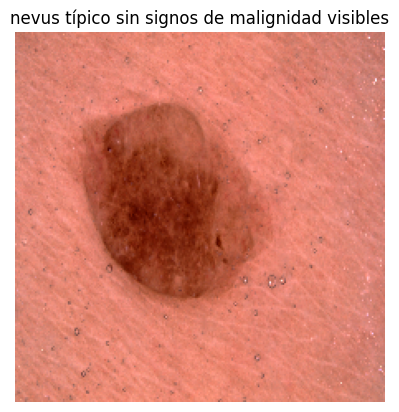

In [118]:
from pathlib import Path
import random

test_dir = Path("/Users/blancasl01/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/test")  # ajusta
all_images = list(test_dir.glob("*/*.jpg"))
img_path = str(random.choice(all_images))

# Preprocesamiento
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
feature_vector = feature_extractor.predict(x)

# Generar caption
caption = generate_caption(model, feature_vector, tokenizer, max_len)

# Mostrar
import matplotlib.pyplot as plt
plt.imshow(np.array(img).astype("uint8"))
plt.axis('off')
plt.title(caption)
plt.show()